In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import subplots
import os
from scipy import stats
import scipy.stats
from scipy.stats import norm

## 1 - Data

### 1.1 Data Loading

Data was retrieved from Wharton Research Data Services.  Namely Accounting/fundamental annual data was downloaded from CRSP/Compustat Merged, monthly stock return and stock information of U.S. stock market was downloaded from CRSP.   During this section we are just creating/merging the dataframes according to the PERMNO (company indentifier).

In [164]:
stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)
stk_data['PRC'] = abs(stk_data['PRC'])
stk_data['MktCap_Mon'] = stk_data['PRC']*stk_data['SHROUT'] 
stk_data['date'] = pd.to_datetime(stk_data['date'], format='%Y-%m-%d')
stk_data['Year'] = stk_data['date'].dt.strftime('%Y')
stk_data['date'] = stk_data['date'].dt.strftime('%Y-%m')
stk_data['SPREAD'] = stk_data['SPREAD']/abs(stk_data['ASKHI'])
stk_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/2824366432.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year
0,10000,1987-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987
1,10000,1987-02,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987
2,10000,1987-03,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987
3,10000,1987-04,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987
4,10000,1987-05,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023
3409591,93436,2023-09,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023
3409592,93436,2023-10,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023
3409593,93436,2023-11,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023


In [165]:
FF_data = pd.read_csv("Data/F&F_Factors.csv")
FF_data.index = FF_data['dateff']
FF_data = FF_data.drop("dateff", axis=1)
FF_data.index = pd.to_datetime(FF_data.index, format="%Y-%m-%d").to_period('M')
FF_data.rename_axis('date', inplace=True)

In [166]:
Acc_Data = pd.read_csv("Data/Acc_Data.csv", header=0)
Acc_Data = Acc_Data.rename(columns={'LPERMNO': 'PERMNO'})
Acc_Data = Acc_Data.rename(columns={'datadate': 'date'})
Acc_Data.drop_duplicates(subset=['PERMNO', 'date'], inplace=True, ignore_index=True)
Acc_Data['date'] = pd.to_datetime(Acc_Data['date'])
Acc_Data['date'] = Acc_Data['date'].dt.year
Acc_Data.sort_values(by=['PERMNO','date'])

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt
86969,12994,1987,INDL,C,D,STD,USD,5.4178,2.750,NaN,0.32,5.369,I,LC,10001,1987-06-30
86970,12994,1988,INDL,C,D,STD,USD,5.5565,2.555,NaN,0.57,5.512,I,LC,10001,1988-06-30
86971,12994,1989,INDL,C,D,STD,USD,6.3147,7.370,NaN,1.21,6.321,I,LC,10001,1989-06-30
86972,12994,1990,INDL,C,D,STD,USD,6.9631,7.175,NaN,1.10,7.179,I,LC,10001,1990-06-29
86973,12994,1991,INDL,C,D,STD,USD,7.4390,6.965,NaN,1.01,7.982,I,LC,10001,1991-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230345,184996,2019,INDL,C,D,STD,USD,36.5635,12627.000,14697.0,-4.92,6618.000,A,LC,93436,2019-12-31
230346,184996,2020,INDL,C,D,STD,USD,23.1510,10888.000,13347.0,0.64,22225.000,A,LC,93436,2020-12-31
230347,184996,2021,INDL,C,D,STD,USD,29.2246,6916.000,8873.0,4.90,30189.000,A,LC,93436,2021-12-31
230348,184996,2022,INDL,C,D,STD,USD,14.1290,3761.000,5748.0,3.62,44704.000,A,LC,93436,2022-12-30


# 2 - Strategies Evaluation

## 2.1 Quality Strategy

### 2.1.1 Defining Quality Score

Quality score is built based on the MSCI quality index metodology (see below some links for information from MSCI)  Here we construct the Return on Equity and the Debt to equity components.  Below there is a function for the EVAR. 

https://www.msci.com/documents/1296102/8473352/Quality-brochure.pdf  https://www.msci.com/documents/10199/96bc76ad-a6cf-477c-a967-9b0132146b90  https://www.msci.com/eqb/methodology/meth_docs/MSCI_Fundamental_Data_Methodology_Mar2020.pdf  https://www.msci.com/eqb/methodology/meth_docs/MSCI_Jun17_Fundamental_Data.pdf 

In [167]:
Acc_Data['ROE'] = Acc_Data['epsfi']/Acc_Data['bkvlps']
Acc_Data['DtE_Rat'] = Acc_Data['dltt']/Acc_Data['seq']
Acc_Data

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
0,1001,1985,INDL,C,D,STD,USD,3.2633,11.908,NaN,0.68,13.014,I,LU,10015,1985-12-31,0.208378,0.915015
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236390,347085,2023,INDL,C,D,STD,USD,4.6842,5.786,9.844,1.05,144.982,A,LC,21069,2023-02-28,0.224158,0.039908
236391,348615,2023,INDL,C,D,STD,USD,2.9612,4.795,11.642,-0.48,97.590,A,LC,23424,2023-12-29,-0.162096,0.049134
236392,348892,2022,INDL,C,D,STD,USD,0.5382,3.109,3.503,-2.26,7.883,A,LC,20846,2022-12-30,-4.199182,0.394393
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [168]:
Quality_df = Acc_Data
company_years = Quality_df.groupby('PERMNO')['date'].nunique()
companies_with_5_years = company_years[company_years >= 5].index
companies_with_5_years

Acc_data_filtered = Acc_Data[Acc_Data['PERMNO'].isin(companies_with_5_years)]
Acc_data_filtered

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [169]:
def calculate_evar(group):
    if len(group) > 4:
        group['EPSg'] = group['epsfi'].pct_change() * 100
        group.loc[4:, 'EVAR'] = group['EPSg'].rolling(window=4).std(ddof=1)
        
    else:
        group['EVAR'] = 0
        
    return group

In [170]:
Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)
Acc_data_filtered

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/3759281452.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)


,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat,EPSg,EVAR
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476,NaN,NaN
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816,233.333333,NaN
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734,-76.666667,NaN
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082,-4271.428571,NaN
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692,-97.260274,2150.937866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486,12.500000,77.771864
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699,16.853933,30.756963
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890,10.576923,31.164466
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000,-57.598039,109.489869


This function builds the quality factor given Return on equity, debt to equity and Earnings variability. Conditions also defined by MSCI.

In [171]:
def Q_score(df):
    mean_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].mean()
    std_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].std()

    df = df.merge(mean_per_year, on='date', suffixes=('', '_mean'))
    df = df.merge(std_per_year, on='date', suffixes=('', '_std'))

    df['ROE Z-Score'] = (df['ROE'] - df['ROE_mean']) / df['ROE_std']
    df['DtE_Rat Z-Score'] = (df['DtE_Rat'] - df['DtE_Rat_mean']) / df['DtE_Rat_std']
    df['EVAR Z-Score'] = (df['EVAR'] - df['EVAR_mean']) / df['EVAR_std']

    df['Quality Z-Score'] = df[['ROE Z-Score', 'DtE_Rat Z-Score', 'EVAR Z-Score']].mean(axis=1)
    
    conditions = [
        (df['ROE'].isnull()), # If ROE is missing
        (df['DtE_Rat'].isnull()) & (~df['EVAR'].isnull()), # If only DtE_Rat is missing
        (~df['DtE_Rat'].isnull()) & (df['EVAR'].isnull()), # If only EVAR is missing
        (df[['ROE', 'DtE_Rat', 'EVAR']].isnull().sum(axis=1) >= 2) # If more than 2 values are missing
    ]
    choices = [
        np.nan, # If ROE is missing
        (df['ROE Z-Score'] + df['EVAR Z-Score']) / 2, # If only DtE_Rat is missing
        (df['ROE Z-Score'] + df['DtE_Rat Z-Score']) / 2, # If only EVAR is missing
        np.nan # If more than 2 values are missing
    ]
    df['Quality Z-Score'] = np.select(conditions, choices, default=df['Quality Z-Score'])

    df['Quality Score'] = df['Quality Z-Score'].apply(lambda x: (1 + x) if x >= 0 else (1 - x)**(-1) if not np.isnan(x) else np.nan)
    
    return df

In [172]:
Quality_df = Acc_data_filtered
Quality_df = Q_score(Quality_df)
Quality_df['date'] = pd.to_datetime(Quality_df['date'], format= "%Y")
Quality_df['date'] = Quality_df['date'].dt.strftime('%Y')
Quality_df = Quality_df[['date', 'PERMNO', 'Quality Score']]
Quality_df.rename(columns={'date': 'Year'}, inplace=True)
Quality_df

,Year,PERMNO,Quality Score
0,1986,10031,1.004270
1,1986,54594,0.961659
2,1986,10066,0.842079
3,1986,10074,1.122387
4,1986,10082,0.955472
...,...,...,...
215501,2023,15920,0.917093
215502,2023,17676,0.980181
215503,2023,18144,0.932924
215504,2023,14615,0.898050


Now, we are going to merge the 2 datasets:

* Monthly stock returns (with montly market cap): "stk_data"
* Yearly deciles sorting: "Quality_df"

In [173]:
merged_df_Q = pd.merge(stk_data, Quality_df, on=['Year', 'PERMNO'], how='left')
merged_df_Q.dropna(subset=['Quality Score'], inplace=True)
merged_df_Q.drop(columns=['Year'], inplace=True)
merged_df_Q

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Quality Score
6,10001,1987-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.00000,6.75000,-0.035714,991.0,NaN,6.689250e+03,0.993328
7,10001,1987-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,6.25000,-0.074074,991.0,NaN,6.193750e+03,0.993328
8,10001,1987-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.37500,6.37500,0.036800,991.0,NaN,6.317625e+03,0.993328
9,10001,1987-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.37500,6.12500,-0.039216,991.0,0.078431,6.069875e+03,0.993328
10,10001,1987-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.25000,5.68750,-0.071429,991.0,0.060000,5.636312e+03,0.993328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3414241,93436,2023-08,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,0.979029
3414242,93436,2023-09,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,0.979029
3414243,93436,2023-10,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,0.979029
3414244,93436,2023-11,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,0.979029


Now we perform the basic data cleaning suggested by Prof. Smajlbegovic in the weekly assignment n.2.
* Selecting only common stocks
* Selecting only stocks listed on the NYSE, NASDAQ or AMEX
* Selecting only non financial firms

**Note:** observations that do not have returns data are removed from the dataset.

In [174]:
merged_df_Q = merged_df_Q[(merged_df_Q['SHRCD'] == 10) | (merged_df_Q['SHRCD'] == 11)] # Selecting only common stock
merged_df_Q = merged_df_Q[(merged_df_Q['EXCHCD'] == 1) | (merged_df_Q['EXCHCD'] == 2) | (merged_df_Q['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
merged_df_Q['SICCD'] = pd.to_numeric(merged_df_Q['SICCD'], errors='coerce')  
merged_df_Q = merged_df_Q[(merged_df_Q['SICCD'] < 6000) | (merged_df_Q['SICCD'] > 6999)]  # Removing financial firms stocks

In [175]:
merged_df_Q['RET'] = pd.to_numeric(merged_df_Q['RET'], errors='coerce')
merged_df_Q = merged_df_Q.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'
merged_df_Q['date'] = pd.to_datetime(merged_df_Q['date'], format='%Y-%m-%d')

In [176]:
def preprocess_dataframe(df):
    df = df[(df['SHRCD'] == 10) | (df['SHRCD'] == 11)] # Selecting only common stock
    df = df[(df['EXCHCD'] == 1) | (df['EXCHCD'] == 2) | (df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
    df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')  
    
    df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
    df = df.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

    return df

In [177]:
merged_df_Q = preprocess_dataframe(merged_df_Q)
merged_df_Q

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Quality Score
6,10001,1987-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.00000,6.75000,-0.035714,991.0,NaN,6.689250e+03,0.993328
7,10001,1987-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,6.25000,-0.074074,991.0,NaN,6.193750e+03,0.993328
8,10001,1987-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.37500,6.37500,0.036800,991.0,NaN,6.317625e+03,0.993328
9,10001,1987-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.37500,6.12500,-0.039216,991.0,0.078431,6.069875e+03,0.993328
10,10001,1987-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.25000,5.68750,-0.071429,991.0,0.060000,5.636312e+03,0.993328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3414241,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,0.979029
3414242,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,0.979029
3414243,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,0.979029
3414244,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,0.979029


### 2.1.2 Deciles Portfolios Sorting

Following the metodology of the paper "Quality minus junk" we create 10 value-weighted deciles based on the quality score computed before.

In [178]:
merged_df_Q = merged_df_Q.sort_values(by='Quality Score', ascending=False)
merged_df_Q.dropna(subset=['Quality Score'], inplace=True)
merged_df_Q['deciles_Q'] = merged_df_Q.groupby(['date'])['Quality Score'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
merged_df_Q

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Quality Score,deciles_Q
2114970,80039,1999-05-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,31.4375,29.00000,-0.029289,18463.0,NaN,535427.00000,43.836353,10
2114977,80039,1999-12-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,24.3750,23.93750,0.081921,19186.0,NaN,459264.87500,43.836353,10
2114972,80039,1999-07-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,32.3750,26.00000,-0.116773,18603.0,NaN,483678.00000,43.836353,10
2114971,80039,1999-06-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.5000,29.43750,0.015086,18603.0,NaN,547625.81250,43.836353,10
2114975,80039,1999-10-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,25.1250,20.87500,-0.173267,19269.0,NaN,402240.37500,43.836353,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074893,79706,1997-04-01,11.0,3.0,7370.0,I V I PUBLISHING INC,3.2500,2.40625,-0.163043,7663.0,NaN,18439.09375,0.031456,1
2074892,79706,1997-03-01,11.0,3.0,7370.0,I V I PUBLISHING INC,3.1875,2.87500,-0.106796,7663.0,NaN,22031.12500,0.031456,1
2074900,79706,1997-11-01,11.0,3.0,7370.0,I V I PUBLISHING INC,4.0000,3.06250,-0.222222,7348.0,NaN,22503.25000,0.031456,1
2074901,79706,1997-12-01,11.0,3.0,7370.0,I V I PUBLISHING INC,3.0000,2.56250,-0.163265,10135.0,NaN,25970.93750,0.031456,1


### 2.1.3 Deciles Portfolios Returns

Here we are computing the value-weighted returns (based on the market cap)

In [179]:
def compute_deciles_port(merged_df):
    copy = merged_df.copy()
    
    grouped = copy.groupby(['date', 'deciles_Q'])

    copy['Total_MktCap_Month_Decile'] = grouped['MktCap_Mon'].transform('sum')
    copy['Weight_Decile'] = copy['MktCap_Mon'] / copy['Total_MktCap_Month_Decile']
    copy['Weighted_RET_Decile'] = copy['RET'] * copy['Weight_Decile']

    portfolio_df = pd.pivot_table(copy, values='Weighted_RET_Decile', index='date', columns='deciles_Q', aggfunc='sum')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [180]:
portfolio_Q = compute_deciles_port(merged_df_Q)
portfolio_Q['H-L'] = portfolio_Q['P10'] - portfolio_Q['P1']
portfolio_Q.index = pd.to_datetime(portfolio_Q.index, format="%Y-%m-%d").to_period('M')
portfolio_Q = portfolio_Q["1990":]
portfolio_Q

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.053279,-0.056957,-0.064265,-0.060143,-0.065824,-0.046522,-0.061508,-0.077182,-0.048495,-0.091607,-0.038328
1990-02,0.003003,0.013152,0.011913,0.017908,0.041118,0.014310,0.044857,0.069855,0.022426,0.021209,0.018206
1990-03,0.028661,0.040634,0.028565,0.031565,0.031619,0.038605,0.018583,0.036051,0.018057,0.054652,0.025990
1990-04,-0.031154,-0.012468,-0.004386,-0.036278,-0.023440,-0.022506,-0.023236,-0.037174,-0.027807,-0.039451,-0.008297
1990-05,0.094494,0.101416,0.084414,0.088363,0.104601,0.127520,0.072662,0.078893,0.081649,0.083240,-0.011254
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.004204,-0.017205,-0.004817,0.012712,-0.028973,-0.020373,-0.026114,-0.024206,0.013005,0.005478,0.009682
2023-09,-0.041458,-0.046773,-0.059169,-0.043425,-0.061569,-0.055685,-0.021384,-0.035014,-0.056469,-0.061119,-0.019661
2023-10,-0.028474,0.025249,-0.035610,-0.021775,-0.010854,-0.018792,-0.050437,-0.095262,-0.000730,-0.029954,-0.001480


### 2.1.4 Returns Analysis

After forming the portfolios, we first compute excess returns (by subtracting the rf column of the FF data) and then merge the two dataframes in a single one.

In [181]:
rf = FF_data['rf']
portfolio_Q = portfolio_Q.sub(rf, axis=0)
portfolio_Q

Quality_FF = pd.concat([portfolio_Q, FF_data], axis=1)
Quality_FF = Quality_FF["1990":]
Quality_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.058979,-0.062657,-0.069965,-0.065843,-0.071524,-0.052222,-0.067208,-0.082882,-0.054195,-0.097307,-0.044028,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,-0.002697,0.007452,0.006213,0.012208,0.035418,0.008610,0.039157,0.064155,0.016726,0.015509,0.012506,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.022261,0.034234,0.022165,0.025165,0.025219,0.032205,0.012183,0.029651,0.011657,0.048252,0.019590,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.038054,-0.019368,-0.011286,-0.043178,-0.030340,-0.029406,-0.030136,-0.044074,-0.034707,-0.046351,-0.015197,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.087694,0.094616,0.077614,0.081563,0.097801,0.120720,0.065862,0.072093,0.074849,0.076440,-0.018054,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.008704,-0.021705,-0.009317,0.008212,-0.033473,-0.024873,-0.030614,-0.028706,0.008505,0.000978,0.005182,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.045758,-0.051073,-0.063469,-0.047725,-0.065869,-0.059985,-0.025684,-0.039314,-0.060769,-0.065419,-0.023961,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.033174,0.020549,-0.040310,-0.026475,-0.015554,-0.023492,-0.055137,-0.099962,-0.005430,-0.034654,-0.006180,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.1.5 Regressions Quality

**1) CAPM**

In [182]:
def CAPM_regression(portfolio_df, Quality_FF):
    factors_CAPM = Quality_FF['mktrf']
    regression_results_CAPM = pd.DataFrame(index=['Alpha CAPM', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_CAPM = sm.add_constant(factors_CAPM)

        model = sm.OLS(portfolio_returns, X_CAPM)
        results = model.fit()

        regression_results_CAPM.loc['Alpha CAPM', portfolio] = results.params[0]
        regression_results_CAPM.loc['Alpha t-stat', portfolio] = results.tvalues[0]
        regression_results_CAPM.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_CAPM.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_CAPM.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_CAPM

In [183]:
CAPM_Quality = CAPM_regression(portfolio_Q, Quality_FF)
CAPM_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.007949,0.007131,0.006906,0.005648,0.006585,0.009386,0.011273,0.011105,0.007201,0.006793,-0.003308
Alpha t-stat,7.145419,6.718976,8.955142,6.463379,6.677045,9.48033,6.899441,9.123896,4.884773,5.212691,-1.95406
β_Mkt-RF,0.95215,0.959188,0.887975,0.974068,0.962017,0.980167,1.154061,1.098931,1.178094,1.148766,0.198583
Mkt-RF t-stat,38.540127,40.692373,51.849506,50.193424,43.922741,44.57782,31.805457,40.654719,35.984517,39.694268,5.281492
Adj.R2,0.784809,0.802606,0.868471,0.860873,0.825711,0.829934,0.712892,0.802313,0.760713,0.794614,0.061983


**2) FF-3**

In [184]:
def FF3_regression(portfolio_df, Quality_FF):
    factors_FF3 = Quality_FF[['mktrf', 'smb', 'hml']]
    regression_results_FF3 = pd.DataFrame(index=['Alpha FF3', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML',  'HML t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF3 = sm.add_constant(factors_FF3)

        model = sm.OLS(portfolio_returns, X_FF3)
        results = model.fit()

        regression_results_FF3.loc['Alpha FF3', portfolio] = results.params[0] 
        regression_results_FF3.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_FF3.loc['β_SMB', portfolio] = results.params[2]
        regression_results_FF3.loc['β_HML', portfolio] = results.params[3]
        
        regression_results_FF3.loc['Alpha t-stat', portfolio] = results.tvalues[0] 
        regression_results_FF3.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_FF3.loc['SMB t-stat', portfolio] = results.tvalues[2]
        regression_results_FF3.loc['HML t-stat', portfolio] = results.tvalues[3]

        regression_results_FF3.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF3

In [185]:
FF3_Quality = FF3_regression(portfolio_Q, Quality_FF)
FF3_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.00825,0.007541,0.007017,0.005736,0.006707,0.009264,0.011485,0.011169,0.007369,0.006799,-0.003603
Alpha t-stat,7.577216,7.575248,9.178226,6.559273,6.835795,9.47055,7.497259,9.786607,5.4674,5.272699,-2.167313
β_Mkt-RF,0.943913,0.96252,0.892874,0.97195,0.947164,0.968594,1.083056,1.047938,1.104921,1.123572,0.180922
Mkt-RF t-stat,37.733038,42.080847,50.832319,48.374769,42.013237,43.096068,30.772832,39.964258,35.678551,37.925348,4.737277
β_SMB,-0.023507,-0.119162,-0.056209,-0.008635,0.059372,0.098845,0.37407,0.28995,0.397582,0.14948,0.177005
SMB t-stat,-0.649836,-3.602663,-2.212935,-0.297211,1.821174,3.041332,7.349895,7.646641,8.877971,3.489178,3.205041
β_HML,-0.150631,-0.202628,-0.05418,-0.044035,-0.063179,0.058495,-0.117174,-0.040492,-0.095981,-0.007266,0.142846
HML t-stat,-4.562738,-6.712662,-2.337257,-1.660703,-2.123499,1.972126,-2.522723,-1.170096,-2.348454,-0.185853,2.834176
Adj.R2,0.794617,0.826976,0.8712,0.86117,0.828104,0.834587,0.748544,0.826822,0.800684,0.799641,0.099112


**3) FF-5**

In [186]:
def FF5_regression(portfolio_df, Quality_FF):
    factors_FF5 = Quality_FF[['mktrf', 'smb', 'hml', 'rmw', 'cma']]
    regression_results_FF5 = pd.DataFrame(index=['Alpha FF5', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML', 'HML t-stat', 'β_RMW', 'RMW t-stat', 'β_CMA', 'CMA t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF5 = sm.add_constant(factors_FF5)

        model = sm.OLS(portfolio_returns, X_FF5)
        results = model.fit()

        regression_results_FF5.loc['Alpha FF5', portfolio] = results.params[0] 
        regression_results_FF5.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_FF5.loc['β_SMB', portfolio] = results.params[2]
        regression_results_FF5.loc['β_HML', portfolio] = results.params[3]
        regression_results_FF5.loc['β_RMW', portfolio] = results.params[4]
        regression_results_FF5.loc['β_CMA', portfolio] = results.params[5]
        
        regression_results_FF5.loc['Alpha t-stat', portfolio] = results.tvalues[0] 
        regression_results_FF5.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_FF5.loc['SMB t-stat', portfolio] = results.tvalues[2]
        regression_results_FF5.loc['HML t-stat', portfolio] = results.tvalues[3]
        regression_results_FF5.loc['RMW t-stat', portfolio] = results.tvalues[4]
        regression_results_FF5.loc['CMA t-stat', portfolio] = results.tvalues[5]

        regression_results_FF5.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF5

In [187]:
FF5_Quality = FF5_regression(portfolio_Q, Quality_FF)
FF5_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.007918,0.007455,0.006031,0.004863,0.006062,0.008125,0.011858,0.011124,0.008617,0.007322,-0.002758
Alpha t-stat,7.010178,7.410636,7.960563,5.468807,6.208285,8.286272,7.470716,9.415971,6.51735,5.604935,-1.634155
β_Mkt-RF,0.951922,0.947065,0.91566,1.009743,0.990232,1.021021,1.078603,1.057979,1.091773,1.126975,0.176903
Mkt-RF t-stat,34.663058,38.719026,49.709019,46.69786,41.710012,42.826957,27.947088,36.82885,33.960696,35.481695,4.310076
β_SMB,0.001355,-0.068503,0.020019,0.014428,0.038391,0.121212,0.334669,0.270723,0.261642,0.070057,0.072741
SMB t-stat,0.03359,-1.906682,0.73989,0.454282,1.100944,3.461422,5.903603,6.415986,5.540865,1.501658,1.206579
β_HML,-0.168394,-0.140749,-0.103171,-0.154222,-0.201975,-0.097056,-0.114459,-0.076862,-0.093447,-0.039999,0.126068
HML t-stat,-3.624442,-3.40127,-3.310622,-4.215829,-5.028632,-2.406333,-1.752975,-1.581514,-1.718148,-0.744365,1.815535
β_RMW,0.070392,0.130169,0.215083,0.07797,-0.038606,0.082198,-0.108116,-0.047661,-0.372093,-0.212768,-0.282857
RMW t-stat,1.388448,2.882685,6.324851,1.953255,-0.880853,1.867617,-1.51743,-0.898708,-6.269603,-3.628608,-3.733014


## 2.2 - Momentum Strategy

In [188]:
stk_data

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year
0,10000,1987-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987
1,10000,1987-02,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987
2,10000,1987-03,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987
3,10000,1987-04,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987
4,10000,1987-05,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023
3409591,93436,2023-09,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023
3409592,93436,2023-10,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023
3409593,93436,2023-11,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023


First of all we drop observations without returns data:

In [189]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

In [190]:
Momentum_df = stk_data
Momentum_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/3862814677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Momentum_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')


In [191]:
Momentum_df = preprocess_dataframe(Momentum_df)

### 2.2.1 Building "Momentum Score"

Momentum was built based on "Is momentum really momentum?" by Novy-Marx, Robert, (2012) where they find the biggest results regarding the MOM12-7, so the returns based on the 12th to 7th months prior. We experimented on two ways of builiding the mom factor through the growth rate and through the comulative sum (GR, CUM).

In [192]:
Momentum_df = Momentum_df.sort_values(by=['PERMNO', 'date'])

window_size = 12

Momentum_df['PRC_7M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size - 5)  # Price at 7 months prior
Momentum_df['PRC_12M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size)  # Price at 12 months prior

Momentum_df['MOM12-7(GR)'] = (Momentum_df['PRC_7M'] - Momentum_df['PRC_12M']) / Momentum_df['PRC_12M']

Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR)
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987,NaN,NaN,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987,NaN,NaN,NaN
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987,NaN,NaN,NaN
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987,NaN,NaN,NaN
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023,173.22000,275.60999,-0.371503
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023,205.71001,265.25000,-0.224467
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023,207.46001,227.53999,-0.088248
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023,164.31000,194.70000,-0.156086


In [193]:
Momentum_df =Momentum_df.sort_values(by=['PERMNO', 'date'])

def compute_rolling_sum(group):
    group['MOM12-7(CUM)'] = group['RET'].shift(7).rolling(window=6).sum()
    return group

Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)

Momentum_df

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/616378836.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR),MOM12-7(CUM)
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987,NaN,NaN,NaN,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987,NaN,NaN,NaN,NaN
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987,NaN,NaN,NaN,NaN
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987,NaN,NaN,NaN,NaN
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023,173.22000,275.60999,-0.371503,-0.357671
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023,205.71001,265.25000,-0.224467,-0.097617
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023,207.46001,227.53999,-0.088248,-0.051521
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023,164.31000,194.70000,-0.156086,-0.117345


### 2.2.2 Momentum Deciles Sorting

The deciles are created based on the comulative sum of the stock returns of the 12-7 months. 

In [194]:
Momentum_df = Momentum_df.sort_values(by='MOM12-7(CUM)', ascending=False)
Momentum_df.dropna(subset=['MOM12-7(CUM)'], inplace=True)
Momentum_df['deciles_Q'] = Momentum_df.groupby(['date'])['MOM12-7(CUM)'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR),MOM12-7(CUM),deciles_Q
1277712,58748,1992-08-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.87500,0.68750,0.047619,16297.0,NaN,11204.1875,1992,1.17188,0.04688,23.997440,24.000000,10
1277713,58748,1992-09-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.62500,0.53125,-0.227273,16822.0,NaN,8936.6875,1992,1.14063,0.04688,23.330845,23.973333,10
1277714,58748,1992-10-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.59375,0.50000,-0.058824,16822.0,NaN,8411.0000,1992,0.79688,0.04688,15.998294,23.671963,10
1277715,58748,1992-11-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.75000,0.75000,0.500000,16822.0,NaN,12616.5000,1992,0.78125,0.04688,15.664889,23.652355,10
1277716,58748,1992-12-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.81250,0.50000,-0.333333,17755.0,NaN,8877.5000,1992,0.71875,0.04688,14.331698,23.572355,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486964,84521,2007-12-01,11.0,2.0,2836.0,CARDIUM THERAPEUTICS INC,2.68990,2.60000,-0.018868,40935.0,NaN,106431.0000,2007,0.03125,4.59375,-0.993197,-3.116634,1
2897789,89169,2020-09-01,11.0,3.0,3841.0,DELCATH SYSTEMS INC,12.46000,11.61000,-0.024370,4036.0,NaN,46857.9600,2020,0.02110,0.92000,-0.977065,-3.118186,1
3327740,92687,2017-09-01,11.0,3.0,8711.0,REAL GOODS SOLAR INC,0.88900,0.87000,0.108280,7481.0,NaN,6508.4700,2017,1.68000,3.81000,-0.559055,-3.276644,1
3314615,92571,2020-06-01,11.0,2.0,1311.0,CAMBER ENERGY INC,2.53000,1.19000,-0.070312,12456.0,NaN,14822.6400,2020,0.85610,0.15130,4.658295,-3.414555,1


### 2.2.3 Momentum Deciles Portfolios Returns

Portfolio returns based on momentum are also value-weighted (compute_deciles_port function does that). 

In [195]:
portfolio_mom = compute_deciles_port(Momentum_df)
portfolio_mom['H-L'] = portfolio_mom['P10'] - portfolio_mom['P1']
portfolio_mom.index = pd.to_datetime(portfolio_mom.index, format="%Y-%m-%d").to_period('M')
portfolio_mom = portfolio_mom['1990':]
portfolio_mom

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.041535,-0.028445,-0.016717,-0.052812,-0.054546,-0.059855,-0.067799,-0.089985,-0.114225,-0.114363,-0.072828
1990-02,0.092998,0.033411,0.052660,0.031256,0.015143,0.019044,0.009286,0.014794,0.015996,0.048780,-0.044218
1990-03,0.075440,0.041456,0.020158,0.013907,0.029546,0.012725,0.016634,0.037570,0.047041,0.050344,-0.025095
1990-04,-0.014223,-0.050825,-0.005310,-0.023075,-0.030686,-0.025891,-0.029016,-0.016612,-0.012587,-0.008259,0.005964
1990-05,0.074237,0.081110,0.086128,0.094301,0.080185,0.079323,0.092801,0.094683,0.114040,0.138348,0.064111
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.029304,-0.009949,-0.025613,-0.028455,-0.029694,-0.000218,-0.007193,-0.004659,-0.005593,-0.019768,0.009537
2023-09,-0.077207,-0.066241,-0.037485,-0.048601,-0.039308,-0.032532,-0.044476,-0.033402,-0.046614,-0.094457,-0.017251
2023-10,-0.135519,-0.068620,-0.043442,-0.026599,-0.003804,-0.023823,-0.022953,-0.000559,-0.027692,-0.045598,0.089921


We subtract risk free rate in order to have the excess returns.

In [196]:
portfolio_mom = portfolio_mom.sub(rf, axis=0)

Momentum_FF = pd.concat([portfolio_mom, FF_data], axis=1)
Momentum_FF = Momentum_FF['1990':]
Momentum_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.047235,-0.034145,-0.022417,-0.058512,-0.060246,-0.065555,-0.073499,-0.095685,-0.119925,-0.120063,-0.078528,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,0.087298,0.027711,0.046960,0.025556,0.009443,0.013344,0.003586,0.009094,0.010296,0.043080,-0.049918,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.069040,0.035056,0.013758,0.007507,0.023146,0.006325,0.010234,0.031170,0.040641,0.043944,-0.031495,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.021123,-0.057725,-0.012210,-0.029975,-0.037586,-0.032791,-0.035916,-0.023512,-0.019487,-0.015159,-0.000936,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.067437,0.074310,0.079328,0.087501,0.073385,0.072523,0.086001,0.087883,0.107240,0.131548,0.057311,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.033804,-0.014449,-0.030113,-0.032955,-0.034194,-0.004718,-0.011693,-0.009159,-0.010093,-0.024268,0.005037,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.081507,-0.070541,-0.041785,-0.052901,-0.043608,-0.036832,-0.048776,-0.037702,-0.050914,-0.098757,-0.021551,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.140219,-0.073320,-0.048142,-0.031299,-0.008504,-0.028523,-0.027653,-0.005259,-0.032392,-0.050298,0.085221,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.2.4 Regressions Momentum

**1) CAPM**

In [197]:
CAPM_MOM = CAPM_regression(portfolio_mom, Momentum_FF)
CAPM_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.015868,0.005851,0.006164,0.004528,0.005138,0.005765,0.006597,0.007728,0.009659,0.018989,0.000969
Alpha t-stat,5.458135,3.173024,4.324318,4.136742,5.329141,7.217831,7.747054,8.230154,6.850725,7.959931,0.262376
β_Mkt-RF,1.548858,1.179568,1.042269,0.990872,0.931168,0.888742,0.904185,0.945058,1.081303,1.456802,-0.09009
Mkt-RF t-stat,23.988802,28.802145,32.92599,40.764462,43.489931,50.104162,47.808125,45.318991,34.532879,27.496645,-1.098515
Adj.R2,0.585313,0.670596,0.726868,0.803167,0.822841,0.860446,0.84879,0.83454,0.745389,0.649762,0.000508


**2) FF-3**

In [198]:
FF3_MOM = FF3_regression(portfolio_mom, Momentum_FF)
FF3_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.01581,0.00543,0.00574,0.003978,0.004731,0.005383,0.006465,0.007853,0.010038,0.020159,0.002198
Alpha t-stat,5.886719,3.058382,4.148528,3.998634,5.232551,7.323014,7.635474,8.378103,7.562691,10.309853,0.616613
β_Mkt-RF,1.42359,1.152108,1.046554,1.02536,0.956911,0.910753,0.915147,0.941874,1.023708,1.299734,-0.122593
Mkt-RF t-stat,23.070687,28.242527,32.92157,44.858514,46.061135,53.926925,47.040694,43.737096,33.569985,28.930935,-1.496921
β_SMB,0.764584,0.266428,0.076902,-0.073581,-0.055823,-0.039392,-0.033658,-0.011076,0.253413,0.657849,-0.102717
SMB t-stat,8.568642,4.516499,1.6729,-2.226104,-1.858167,-1.612962,-1.196426,-0.355676,5.74666,10.126187,-0.867333
β_HML,0.007636,0.204112,0.210832,0.278358,0.205935,0.193151,0.067439,-0.062304,-0.197472,-0.60662,-0.614775
HML t-stat,0.093774,3.791404,5.025454,9.22768,7.511276,8.666088,2.626719,-2.192286,-4.906822,-10.231638,-5.688131
Adj.R2,0.647412,0.695759,0.743577,0.83797,0.844739,0.88223,0.851061,0.835742,0.775197,0.765571,0.072157


**3) FF-5**

In [199]:
FF5_MOM = FF5_regression(portfolio_mom,Momentum_FF)
FF5_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.018242,0.006258,0.005746,0.003535,0.004052,0.004612,0.005623,0.00723,0.010759,0.021656,0.001251
Alpha t-stat,6.624874,3.443747,4.050849,3.472521,4.367312,6.209929,6.509586,7.525518,7.915493,10.960786,0.339106
β_Mkt-RF,1.345479,1.101458,1.028129,1.02841,0.974361,0.929493,0.949361,0.972366,1.013446,1.276905,-0.066723
Mkt-RF t-stat,20.095859,24.92693,29.807324,41.546912,43.189153,51.474873,45.196919,41.624873,30.664396,26.579653,-0.743654
β_SMB,0.631727,0.281784,0.122429,-0.021234,-0.007747,0.0179,-0.005774,-0.003508,0.181505,0.512513,-0.115175
SMB t-stat,6.423703,4.341536,2.416504,-0.584018,-0.233785,0.674895,-0.187134,-0.102248,3.738943,7.263104,-0.873937
β_HML,0.211533,0.364737,0.28044,0.283594,0.165532,0.151345,-0.030356,-0.154297,-0.185924,-0.576839,-0.790699
HML t-stat,1.867489,4.878999,4.805799,6.772034,4.336972,4.954119,-0.854214,-3.904189,-3.325212,-7.097323,-5.209023
β_RMW,-0.390889,0.020273,0.115089,0.142444,0.136934,0.162328,0.089479,0.033134,-0.198206,-0.401473,-0.010281
RMW t-stat,-3.162478,0.248517,1.807389,3.117168,3.287828,4.869522,2.307492,0.76832,-3.24859,-4.526792,-0.062068


## 2.3 Low Volatility Strategy

In [200]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/115396609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')


In [201]:
LowVol_df = stk_data
LowVol_df['date'] = pd.to_datetime(LowVol_df['date'], format='%Y-%m-%d')

In [202]:
LowVol_df = preprocess_dataframe(LowVol_df)
LowVol_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023


### 2.3.1 Building Low-Volatility Score

In [203]:
LowVol_df = LowVol_df.sort_values(by=['PERMNO', 'date'])

def compute_rolling_sum(group):
    group['RET_VAR'] = group['RET'].rolling(window=36).var()
    return group

LowVol_df = LowVol_df.groupby('PERMNO').apply(compute_rolling_sum)
LowVol_df

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/967580346.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  LowVol_df = LowVol_df.groupby('PERMNO').apply(compute_rolling_sum)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year,RET_VAR
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987,NaN
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987,NaN
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987,NaN
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023,0.038574
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023,0.037853
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023,0.038888
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023,0.034263


### 2.3.2 Volatility Deciles Sorting

In the low vol strategy we follow the Blitz et al (2007) methodology considering the variance of the previous 36 months to rank stocks in deciles.

In [204]:
LowVol_df = LowVol_df.sort_values(by='RET_VAR', ascending=True)
LowVol_df.dropna(subset=['RET_VAR'], inplace=True)
LowVol_df['deciles_Q'] = LowVol_df.groupby(['date'])['RET_VAR'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
LowVol_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year,RET_VAR,deciles_Q
1130646,47504,1992-03-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,-13.00000,13.00000,0.000000,810.0,0.076923,10530.00000,1992,0.000042,1
1130645,47504,1992-02-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,-13.00000,13.00000,0.000000,810.0,0.076923,10530.00000,1992,0.000048,1
1130644,47504,1992-01-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,-13.00000,13.00000,0.000000,810.0,0.076923,10530.00000,1992,0.000048,1
1130643,47504,1991-12-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,-13.00000,13.00000,0.000000,810.0,0.076923,10530.00000,1991,0.000048,1
1130642,47504,1991-11-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,-13.00000,13.00000,0.000000,816.0,0.076923,10608.00000,1991,0.000048,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277713,58748,1992-09-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.62500,0.53125,-0.227273,16822.0,NaN,8936.68750,1992,16.214424,10
1277711,58748,1992-07-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.68750,0.65625,-0.045455,16297.0,NaN,10694.90625,1992,16.215726,10
1277709,58748,1992-05-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,-0.98438,0.71875,-0.080000,16184.0,0.063492,11632.25000,1992,16.216260,10
1277710,58748,1992-06-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.93750,0.68750,-0.043478,16297.0,NaN,11204.18750,1992,16.216646,10


### 2.3.3 Volatility Deciles Portfolios Returns

In [205]:
portfolio_LowVol = compute_deciles_port(LowVol_df)
portfolio_LowVol['L-H'] = portfolio_LowVol['P1'] - portfolio_LowVol['P10']
portfolio_LowVol.index = pd.to_datetime(portfolio_LowVol.index, format="%Y-%m-%d").to_period('M')
portfolio_LowVol = portfolio_LowVol['1990':]
portfolio_LowVol

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
date,,,,,,,,,,,
1990-01,-0.066149,-0.056857,-0.075442,-0.094646,-0.083272,-0.043450,-0.060716,-0.107197,-0.092055,-0.020281,-0.045868
1990-02,-0.000580,0.018645,0.018146,0.033925,0.056635,0.050247,0.039728,0.076186,0.085640,0.164111,-0.164690
1990-03,0.016179,0.027949,0.030463,0.020599,0.043993,0.047576,0.063604,0.107147,0.125742,0.074551,-0.058372
1990-04,-0.015876,-0.022066,-0.027503,-0.022861,-0.031305,-0.035301,-0.036977,-0.034548,-0.007356,0.023633,-0.039509
1990-05,0.079613,0.087043,0.100736,0.112972,0.134549,0.108843,0.142103,0.127692,0.148033,0.147833,-0.068219
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.014466,-0.015662,0.002053,-0.003087,-0.022035,-0.044937,0.010982,-0.036284,-0.060193,-0.025635,0.011169
2023-09,-0.032151,-0.052670,-0.036844,-0.057010,-0.047422,-0.041517,-0.089924,-0.037931,-0.041302,-0.044870,0.012719
2023-10,0.008532,-0.021987,-0.032615,-0.012368,-0.059612,-0.032618,-0.061470,-0.165042,-0.103131,-0.099820,0.108352


In [206]:
portfolio_LowVol = portfolio_LowVol.sub(rf, axis=0)
LowVol_FF = pd.concat([portfolio_LowVol, FF_data], axis=1)
LowVol_FF = LowVol_FF['1990':]
LowVol_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.071849,-0.062557,-0.081142,-0.100346,-0.088972,-0.049150,-0.066416,-0.112897,-0.097755,-0.025981,-0.051568,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,-0.006280,0.012945,0.012446,0.028225,0.050935,0.044547,0.034028,0.070486,0.079940,0.158411,-0.170390,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.009779,0.021549,0.024063,0.014199,0.037593,0.041176,0.057204,0.100747,0.119342,0.068151,-0.064772,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.022776,-0.028966,-0.034403,-0.029761,-0.038205,-0.042201,-0.043877,-0.041448,-0.014256,0.016733,-0.046409,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.072813,0.080243,0.093936,0.106172,0.127749,0.102043,0.135303,0.120892,0.141233,0.141033,-0.075019,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.018966,-0.020162,-0.002447,-0.007587,-0.026535,-0.049437,0.006482,-0.040784,-0.064693,-0.030135,0.006669,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.036451,-0.056970,-0.041144,-0.061310,-0.051722,-0.045817,-0.094224,-0.042231,-0.045602,-0.049170,0.008419,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,0.003832,-0.026687,-0.037315,-0.017068,-0.064312,-0.037318,-0.066170,-0.169742,-0.107831,-0.104520,0.103652,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.3.4 Regressions Low Vol

**1) CAPM**

In [207]:
CAPM_LOWVOL = CAPM_regression(portfolio_LowVol, LowVol_FF)
CAPM_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha CAPM,0.004945,0.003716,0.006591,0.00767,0.006236,0.011598,0.014376,0.016388,0.026084,0.059173,-0.05638
Alpha t-stat,5.594833,4.330312,6.932662,7.890337,5.180718,7.368365,7.498177,5.9083,6.67334,7.283754,-6.627114
β_Mkt-RF,0.571247,0.858781,1.008867,1.18018,1.35066,1.462926,1.564792,1.839925,2.055728,2.280646,-1.707433
Mkt-RF t-stat,29.102903,45.059903,47.785665,54.67106,50.525331,41.850716,36.750818,29.868435,23.681604,12.640725,-9.03696
Adj.R2,0.675174,0.83295,0.848669,0.880115,0.862445,0.811354,0.768305,0.68647,0.579032,0.280649,0.165414


**2) FF-3**

In [208]:
FF3_LOWVOL = FF3_regression(portfolio_LowVol, LowVol_FF)
FF3_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha FF3,0.004666,0.003237,0.006167,0.007278,0.006422,0.011824,0.014879,0.017203,0.027347,0.060438,-0.057924
Alpha t-stat,6.418955,4.655651,7.096634,7.918837,5.735675,8.308881,8.855052,7.330707,8.16566,8.441029,-7.912844
β_Mkt-RF,0.632978,0.913571,1.04628,1.188823,1.295441,1.380108,1.450812,1.658005,1.809129,1.810234,-1.175993
Mkt-RF t-stat,37.903073,57.196803,52.405946,56.301307,50.356835,42.209834,37.578607,30.750778,23.510953,11.003906,-6.99208
β_SMB,-0.302192,-0.212135,-0.121532,0.043082,0.285782,0.441334,0.560865,0.892623,1.171564,2.511852,-2.810026
SMB t-stat,-12.513523,-9.184435,-4.209551,1.410925,7.682234,9.334243,10.046136,11.448524,10.528784,10.558871,-11.553759
β_HML,0.149013,0.247125,0.216525,0.195776,-0.101609,-0.126359,-0.269216,-0.434907,-0.66824,-0.707375,0.855869
HML t-stat,6.761296,11.72376,8.21791,7.025581,-2.992917,-2.928377,-5.283853,-6.112058,-6.58042,-3.258232,3.855932
Adj.R2,0.781119,0.890779,0.874022,0.893221,0.881416,0.846358,0.82267,0.776402,0.692076,0.443264,0.384355


**3) FF-5**

In [209]:
FF5_LOWVOL = FF5_regression(portfolio_LowVol,LowVol_FF)
FF5_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha FF5,0.00265,0.001559,0.004805,0.007207,0.007004,0.013709,0.017171,0.021072,0.032433,0.066588,-0.0661
Alpha t-stat,4.058826,2.444446,5.814843,7.753675,6.145874,9.545311,10.184785,9.056103,9.844029,9.307501,-9.095411
β_Mkt-RF,0.706545,0.962441,1.074078,1.174485,1.259017,1.317387,1.358608,1.531253,1.676887,1.724679,-1.016284
Mkt-RF t-stat,44.498232,62.069587,53.456375,51.968775,45.438197,37.724117,33.140911,27.064813,20.932143,9.91447,-5.751211
β_SMB,-0.214424,-0.107884,-0.007043,0.0888,0.298723,0.343878,0.482529,0.687569,0.815495,1.893914,-2.1043
SMB t-stat,-9.19398,-4.736849,-0.238629,2.675067,7.339806,6.704053,8.013465,8.273718,6.930393,7.412216,-8.107342
β_HML,-0.053479,0.12547,0.162773,0.252824,0.014432,0.039948,-0.006563,-0.10109,-0.359746,-0.616264,0.560459
HML t-stat,-1.990834,4.782946,4.788471,6.612455,0.307866,0.676154,-0.094622,-1.056128,-2.654333,-2.094005,1.874725
β_RMW,0.267395,0.301539,0.320359,0.117311,0.019697,-0.288995,-0.249737,-0.605892,-1.015442,-1.702172,1.969869
RMW t-stat,9.122206,10.533989,8.636635,2.811753,0.385065,-4.482698,-3.299873,-5.800921,-6.866082,-5.300396,6.038448


## 2.4 Short Term Reversal

In [210]:
stk_data

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023


In [211]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

In [212]:
STR_df = stk_data

In [213]:
STR_df = preprocess_dataframe(STR_df)
#STR_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')
STR_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023


### 2.4.1 STR Deciles Sorting

In [214]:
STR_df = STR_df.sort_values(by=['PERMNO', 'date'])
STR_df['STR_Ret'] = STR_df.groupby('PERMNO')['RET'].shift(1)

STR_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year,STR_Ret
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.51563,0.40625,-0.212121,3893.0,0.121211,1.581531e+03,1987,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.43750,0.40625,0.000000,3893.0,0.142857,1.581531e+03,1987,-0.212121
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.40625,0.25000,-0.384615,3893.0,0.153846,9.732500e+02,1987,0.000000
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.23438,-0.062500,3893.0,0.133330,9.124413e+02,1987,-0.384615
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,-0.23438,0.21875,-0.066667,3893.0,0.266661,8.515938e+02,1987,-0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,NaN,8.191443e+08,2023,0.021622
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,NaN,7.954494e+08,2023,-0.034962
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,NaN,6.384545e+08,2023,-0.030456
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,NaN,7.631954e+08,2023,-0.197346


### 2.4.2 STR Deciles Sorting

In [215]:
STR_df = STR_df.sort_values(by='STR_Ret', ascending=False)
STR_df.dropna(subset=['STR_Ret'], inplace=True)
STR_df['deciles_Q'] = STR_df.groupby(['date'])['STR_Ret'].transform(lambda x: pd.qcut(x, 5, labels=False) + 1)
STR_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,SPREAD,MktCap_Mon,Year,STR_Ret,deciles_Q
1277706,58748,1992-02-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,-1.51563,1.14063,-0.026667,16184.0,0.020618,1.845996e+04,1992,24.000000,5
555799,16400,2019-02-01,11.0,3.0,9999.0,PHUNWARE INC,308.39999,29.54000,-0.900806,27253.0,NaN,8.050536e+05,2019,19.883589,5
1205304,53154,1993-09-01,10.0,3.0,3390.0,METALLURGICAL INDUSTRIES INC,1.06250,0.46875,-0.250000,1973.0,0.294118,9.248438e+02,1993,19.000000,5
1140272,48072,2021-02-01,11.0,3.0,3651.0,KOSS CORP,35.00000,16.71000,-0.738906,7616.0,NaN,1.272634e+05,2021,17.604650,5
2916084,89301,2021-02-01,11.0,1.0,5945.0,GAMESTOP CORP NEW,225.00000,101.74000,-0.686954,69747.0,NaN,7.096060e+06,2021,16.250530,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177691,80640,2009-03-01,11.0,3.0,2830.0,LA JOLLA PHARMACEUTICAL CO,0.23000,0.18000,1.926829,65723.0,NaN,1.183014e+04,2009,-0.972173,1
776026,21025,2023-09-01,11.0,3.0,9999.0,BETTER HOME & FINANCE HLDG CO,0.81010,0.47900,-0.482162,356443.0,NaN,1.707362e+05,2023,-0.979896,1
849004,23317,2001-12-01,11.0,1.0,1311.0,ENRON CORP,1.01000,0.60000,1.307693,743905.0,NaN,4.463430e+05,2001,-0.981295,1
2541096,85320,2018-08-01,11.0,3.0,7379.0,HELIOS & MATHESON ANALYTICS INC,0.22800,0.02160,-0.956452,1107057.0,NaN,2.391243e+04,2018,-0.993600,1


### 2.4.3 STR Deciles Portfolio Returns

In [216]:
portfolio_STR = compute_deciles_port(STR_df)
portfolio_STR['L-H'] = portfolio_STR['P1'] - portfolio_STR['P5']
portfolio_STR.index = pd.to_datetime(portfolio_STR.index, format="%Y-%m-%d").to_period('M')
portfolio_STR = portfolio_STR['1990':]
portfolio_STR

,P1,P2,P3,P4,P5,L-H
date,,,,,,
1990-01,-0.080893,-0.053055,-0.064593,-0.068015,-0.074538,-0.006354
1990-02,0.049518,0.010084,0.017324,0.022132,0.042559,0.006959
1990-03,0.041852,0.034285,0.020632,0.023739,0.036148,0.005704
1990-04,-0.038755,-0.035103,-0.017255,-0.013914,-0.021805,-0.016950
1990-05,0.108591,0.087718,0.089259,0.108584,0.102827,0.005764
...,...,...,...,...,...,...
2023-08,-0.009551,-0.004521,-0.015227,-0.010594,-0.056535,0.046984
2023-09,-0.091394,-0.043735,-0.048506,-0.038001,-0.047131,-0.044263
2023-10,-0.053406,-0.030811,-0.021673,-0.014611,-0.018584,-0.034822


In [217]:
portfolio_STR = portfolio_STR.sub(rf, axis=0)
STR_FF = pd.concat([portfolio_STR, FF_data], axis=1)
STR_FF = STR_FF['1990':]
STR_FF

,P1,P2,P3,P4,P5,L-H,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,
1990-01,-0.086593,-0.058755,-0.070293,-0.073715,-0.080238,-0.012054,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,0.043818,0.004384,0.011624,0.016432,0.036859,0.001259,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.035452,0.027885,0.014232,0.017339,0.029748,-0.000696,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.045655,-0.042003,-0.024155,-0.020814,-0.028705,-0.023850,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.101791,0.080918,0.082459,0.101784,0.096027,-0.001036,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.014051,-0.009021,-0.019727,-0.015094,-0.061035,0.042484,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.095694,-0.048035,-0.052806,-0.042301,-0.051431,-0.048563,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.058106,-0.035511,-0.026373,-0.019311,-0.023284,-0.039522,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.4.4 Regressions STR

In [218]:
CAPM_STR = CAPM_regression(portfolio_STR, STR_FF)
CAPM_STR

,P1,P2,P3,P4,P5,L-H
Alpha CAPM,0.010319,0.008529,0.006432,0.006371,0.009642,-0.001476
Alpha t-stat,5.267396,8.438158,11.236732,8.527371,5.715914,-0.495209
β_Mkt-RF,1.460307,1.103121,0.93172,0.919894,1.058676,0.403597
Mkt-RF t-stat,33.566025,49.143792,73.288465,55.44091,28.258767,6.097729
Adj.R2,0.734452,0.855731,0.929551,0.883036,0.662117,0.081642


**2) FF-3**

In [219]:
CAPM_STR = FF3_regression(portfolio_STR, STR_FF)
CAPM_STR

,P1,P2,P3,P4,P5,L-H
Alpha FF3,0.010541,0.008583,0.006366,0.00633,0.009986,-0.001597
Alpha t-stat,5.719612,8.563857,11.197369,8.458515,6.220374,-0.535065
β_Mkt-RF,1.377513,1.083755,0.941648,0.926318,0.993684,0.385092
Mkt-RF t-stat,32.531167,47.062149,72.085931,53.875756,26.938998,5.616527
β_SMB,0.442114,0.102808,-0.043449,-0.028508,0.306036,0.140096
SMB t-stat,7.220212,3.087287,-2.300144,-1.146601,5.73742,1.412995
β_HML,-0.124452,-0.03036,0.03451,0.021525,-0.181712,0.056741
HML t-stat,-2.227025,-0.998996,2.001809,0.948639,-3.732814,0.627082
Adj.R2,0.765819,0.858653,0.93076,0.883083,0.69508,0.082618


**3) FF-5**

In [220]:
CAPM_STR = FF5_regression(portfolio_STR, STR_FF)
CAPM_STR

,P1,P2,P3,P4,P5,L-H
Alpha FF5,0.012493,0.009059,0.005857,0.006146,0.010673,-0.000343
Alpha t-stat,6.677063,8.726924,10.0435,8.004263,6.483114,-0.111901
β_Mkt-RF,1.294572,1.065214,0.958145,0.941939,0.988218,0.308205
Mkt-RF t-stat,28.455379,42.202199,67.571889,50.450725,24.686468,4.137865
β_SMB,0.386517,0.085026,-0.016,-0.042972,0.226712,0.163843
SMB t-stat,5.784063,2.293387,-0.768203,-1.566959,3.855743,1.497583
β_HML,0.115977,0.021887,-0.008725,-0.030736,-0.18704,0.30069
HML t-stat,1.506817,0.51254,-0.363702,-0.973063,-2.761787,2.386193
β_RMW,-0.184551,-0.055691,0.080911,-0.032488,-0.216203,0.031954
RMW t-stat,-2.19735,-1.195156,3.090903,-0.942555,-2.925576,0.232382


## 2.5 Altman Z-Score

### 2.5.1 Building Altman Z-Score

Altman Z-Score is computed as:

$$Z Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E$$

with:

* $A = \frac{working \space capital}{total \space assets}$

* $B = \frac{retained \space earnings}{total \space assets}$

* $C = \frac{EBIT}{total \space assets}$

* $D = \frac{market \space value \space of \space equity}{total \space liabilities}$

* $E = \frac{sales}{total \space assets}$

As defined by [Altman (1968) - Financial ratios, discriminant analysis and the prediction of corporate bankruptcy](https://www.jstor.org/stable/2978933?seq=1)

In [221]:
Z_Data = pd.read_csv("Data/Altman_Z_Data.csv", header=0)
Z_Data = Z_Data.rename(columns={'LPERMNO': 'PERMNO'})
Z_Data = Z_Data.rename(columns={'datadate': 'date'})
Z_Data.drop_duplicates(subset=['PERMNO', 'date'], inplace=True, ignore_index=True)
Z_Data['date'] = pd.to_datetime(Z_Data['date'])
Z_Data['date'] = Z_Data['date'].dt.year
Z_Data.sort_values(by=['PERMNO','date'])

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,at,ebit,lt,re,sale,wcap,costat,mkvalt,LINKTYPE,PERMNO,MthCalDt
62686,12994,1990,INDL,C,D,STD,USD,18.881,2.459,11.702,5.829,23.227,1.293,I,NaN,LC,10001,1990-06-29
62687,12994,1991,INDL,C,D,STD,USD,19.599,2.414,11.617,6.309,23.850,1.654,I,NaN,LC,10001,1991-06-28
62688,12994,1992,INDL,C,D,STD,USD,22.286,1.922,14.115,6.490,22.950,-0.574,I,NaN,LC,10001,1992-06-30
62689,12994,1993,INDL,C,D,STD,USD,27.434,2.741,18.701,6.850,27.629,1.880,I,NaN,LC,10001,1993-06-30
62690,12994,1994,INDL,C,D,STD,USD,28.095,2.636,18.702,7.420,27.680,1.078,I,NaN,LC,10001,1994-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202298,184996,2019,INDL,C,D,STD,USD,34309.000,80.000,26199.000,-6119.000,24578.000,1436.000,A,75717.73,LC,93436,2019-12-31
202299,184996,2020,INDL,C,D,STD,USD,52148.000,2184.000,28469.000,-5036.000,31536.000,12469.000,A,677443.20,LC,93436,2020-12-31
202300,184996,2021,INDL,C,D,STD,USD,62131.000,6496.000,30548.000,385.000,53823.000,7395.000,A,1091653.74,LC,93436,2021-12-31
202301,184996,2022,INDL,C,D,STD,USD,82338.000,13832.000,36440.000,12524.000,81462.000,14208.000,A,389741.52,LC,93436,2022-12-30


**Computing Z-Score Components:**

*Since there are many missing values for the market value, that is computed in the Stock returns dataset and then the D factors is computed after the merging*

In [222]:
Z_Data['A'] = Z_Data['wcap']/Z_Data['at']
Z_Data['B'] = Z_Data['re']/Z_Data['at']
Z_Data['C'] = Z_Data['ebit']/Z_Data['at']
Z_Data['E'] = Z_Data['sale']/Z_Data['at']
Z_Data

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,at,ebit,lt,...,wcap,costat,mkvalt,LINKTYPE,PERMNO,MthCalDt,A,B,C,E
0,1003,1990,INDL,C,D,STD,USD,10.109,-2.322,10.525,...,-1.259,I,NaN,LU,10031,NaN,-0.124542,-0.403403,-0.229696,1.905925
1,1004,1990,INDL,C,D,STD,USD,388.521,46.851,198.973,...,184.932,A,NaN,LU,54594,1990-05-31,0.475990,0.240520,0.120588,1.145048
2,1004,1991,INDL,C,D,STD,USD,379.958,33.701,186.180,...,189.172,A,NaN,LU,54594,1991-05-31,0.497876,0.262695,0.088697,1.227878
3,1004,1992,INDL,C,D,STD,USD,395.351,26.530,198.614,...,197.246,A,NaN,LU,54594,1992-05-29,0.498914,0.259703,0.067105,1.069068
4,1004,1993,INDL,C,D,STD,USD,365.151,16.343,175.935,...,193.399,A,NaN,LU,54594,1993-05-28,0.529641,0.261067,0.044757,1.048279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208372,348615,2023,INDL,C,D,STD,USD,323.859,-10.385,226.269,...,-0.373,A,627.7788,LC,23424,2023-12-29,-0.001152,-0.172736,-0.032066,0.727141
208373,348892,2022,INDL,C,D,STD,USD,15.316,-19.782,7.433,...,2.790,A,NaN,LC,20846,2022-12-30,0.182162,-4.266845,-1.291590,0.000000
208374,349972,2022,INDL,C,D,STD,USD,28.064,-14.911,3.433,...,23.811,A,12.1815,LC,15642,2022-12-30,0.848454,-1.065315,-0.531321,0.000000
208375,349972,2023,INDL,C,D,STD,USD,14.924,-16.378,2.847,...,11.221,A,14.7858,LC,15642,2023-12-29,0.751876,-3.043219,-1.097427,0.000000


Now we merge accounting characteristics with returns data

In [223]:
Z_Data['date'] = pd.to_datetime(Z_Data['date'], format= "%Y")
Z_Data['date'] = Z_Data['date'].dt.strftime('%Y')
Z_Data.rename(columns={'date': 'Year'}, inplace=True)
Z_Data

,gvkey,Year,indfmt,consol,popsrc,datafmt,curcd,at,ebit,lt,...,wcap,costat,mkvalt,LINKTYPE,PERMNO,MthCalDt,A,B,C,E
0,1003,1990,INDL,C,D,STD,USD,10.109,-2.322,10.525,...,-1.259,I,NaN,LU,10031,NaN,-0.124542,-0.403403,-0.229696,1.905925
1,1004,1990,INDL,C,D,STD,USD,388.521,46.851,198.973,...,184.932,A,NaN,LU,54594,1990-05-31,0.475990,0.240520,0.120588,1.145048
2,1004,1991,INDL,C,D,STD,USD,379.958,33.701,186.180,...,189.172,A,NaN,LU,54594,1991-05-31,0.497876,0.262695,0.088697,1.227878
3,1004,1992,INDL,C,D,STD,USD,395.351,26.530,198.614,...,197.246,A,NaN,LU,54594,1992-05-29,0.498914,0.259703,0.067105,1.069068
4,1004,1993,INDL,C,D,STD,USD,365.151,16.343,175.935,...,193.399,A,NaN,LU,54594,1993-05-28,0.529641,0.261067,0.044757,1.048279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208372,348615,2023,INDL,C,D,STD,USD,323.859,-10.385,226.269,...,-0.373,A,627.7788,LC,23424,2023-12-29,-0.001152,-0.172736,-0.032066,0.727141
208373,348892,2022,INDL,C,D,STD,USD,15.316,-19.782,7.433,...,2.790,A,NaN,LC,20846,2022-12-30,0.182162,-4.266845,-1.291590,0.000000
208374,349972,2022,INDL,C,D,STD,USD,28.064,-14.911,3.433,...,23.811,A,12.1815,LC,15642,2022-12-30,0.848454,-1.065315,-0.531321,0.000000
208375,349972,2023,INDL,C,D,STD,USD,14.924,-16.378,2.847,...,11.221,A,14.7858,LC,15642,2023-12-29,0.751876,-3.043219,-1.097427,0.000000


In [224]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

In [225]:
merged_df = pd.merge(stk_data, Z_Data, on=['Year', 'PERMNO'], how='left')
merged_df.drop(columns=['Year'], inplace=True)
merged_df['D'] = merged_df['MktCap_Mon']/(merged_df['lt']*1000000)
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df['Z-Score'] = 1.2*merged_df['A'] + 1.4*merged_df['B'] + 3.3*merged_df['C'] + 0.6*merged_df['D'] + 1.0*merged_df['E']
merged_df.dropna(subset=['Z-Score'], inplace=True)
Z_df = merged_df
Z_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,...,costat,mkvalt,LINKTYPE,MthCalDt,A,B,C,E,D,Z-Score
41,10001,1990-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,10.12500,9.93750,-0.018519,1022.0,...,I,NaN,LC,1990-06-29,0.068482,0.308723,0.130237,1.230178,0.000868,2.174871
42,10001,1990-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,10.00000,9.87500,-0.006289,1022.0,...,I,NaN,LC,1990-06-29,0.068482,0.308723,0.130237,1.230178,0.000862,2.174867
43,10001,1990-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,10.12500,9.87500,0.012658,1027.0,...,I,NaN,LC,1990-06-29,0.068482,0.308723,0.130237,1.230178,0.000867,2.174870
44,10001,1990-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,10.00000,9.87500,0.000000,1027.0,...,I,NaN,LC,1990-06-29,0.068482,0.308723,0.130237,1.230178,0.000867,2.174870
45,10001,1990-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,10.00000,9.75000,-0.012658,1027.0,...,I,NaN,LC,1990-06-29,0.068482,0.308723,0.130237,1.230178,0.000856,2.174863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295698,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,261.07001,258.07999,-0.034962,3173994.0,...,A,791408.8,LC,2023-12-29,0.195727,0.260172,0.083391,0.907661,0.019046,1.793392
3295699,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,276.04001,250.22000,-0.030456,3179000.0,...,A,791408.8,LC,2023-12-29,0.195727,0.260172,0.083391,0.907661,0.018495,1.793062
3295700,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,263.62000,200.84000,-0.197346,3178921.0,...,A,791408.8,LC,2023-12-29,0.195727,0.260172,0.083391,0.907661,0.014845,1.790871
3295701,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,246.72000,240.08000,0.195379,3178921.0,...,A,791408.8,LC,2023-12-29,0.195727,0.260172,0.083391,0.907661,0.017745,1.792612


### 2.5.2 Z-Score Deciles Sorting

In [226]:
Z_df = Z_df.sort_values(by='Z-Score', ascending=False)
Z_df.dropna(subset=['Z-Score'], inplace=True)
Z_df['deciles_Q'] = Z_df.groupby(['date'])['Z-Score'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
Z_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,ASKHI,PRC,RET,SHROUT,...,mkvalt,LINKTYPE,MthCalDt,A,B,C,E,D,Z-Score,deciles_Q
177068,11669,1991-12-01,10.0,3.0,5090.0,OREXANA CORP,-0.98438,0.98438,0.750000,8197.0,...,NaN,LU,1991-03-28,0.800375,-2.411434,-3.533271,87.050609,0.037882,72.997987,10
177065,11669,1991-09-01,10.0,3.0,5090.0,OREXANA CORP,-0.79688,0.71875,0.769231,8197.0,...,NaN,LU,1991-03-28,0.800375,-2.411434,-3.533271,87.050609,0.027660,72.991854,10
177066,11669,1991-10-01,10.0,3.0,5090.0,OREXANA CORP,-0.71875,0.71875,0.000000,8197.0,...,NaN,LU,1991-03-28,0.800375,-2.411434,-3.533271,87.050609,0.027660,72.991854,10
177067,11669,1991-11-01,10.0,3.0,5090.0,OREXANA CORP,-0.76563,0.56250,-0.217391,8197.0,...,NaN,LU,1991-03-28,0.800375,-2.411434,-3.533271,87.050609,0.021647,72.988246,10
177058,11669,1991-02-01,10.0,3.0,5090.0,OREXANA CORP,-0.60938,0.56250,0.028571,6897.0,...,NaN,LU,1991-03-28,0.800375,-2.411434,-3.533271,87.050609,0.018214,72.986186,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745996,77238,2003-05-01,11.0,3.0,7990.0,NUWAY MEDICAL INC,0.26000,0.22000,2.142857,16005.0,...,1.4537,LU,NaN,-2924.000000,-25824.000000,-2348.000000,0.000000,0.001204,-47410.799278,1
1745992,77238,2003-01-01,11.0,3.0,7990.0,NUWAY MEDICAL INC,0.25900,0.14000,-0.481481,16005.0,...,1.4537,LU,NaN,-2924.000000,-25824.000000,-2348.000000,0.000000,0.000766,-47410.799540,1
1745993,77238,2003-02-01,11.0,3.0,7990.0,NUWAY MEDICAL INC,0.20100,0.12000,-0.142857,16005.0,...,1.4537,LU,NaN,-2924.000000,-25824.000000,-2348.000000,0.000000,0.000657,-47410.799606,1
1745994,77238,2003-03-01,11.0,3.0,7990.0,NUWAY MEDICAL INC,0.12000,0.12000,0.000000,16005.0,...,1.4537,LU,NaN,-2924.000000,-25824.000000,-2348.000000,0.000000,0.000657,-47410.799606,1


### 2.5.3 Z-Score Deciles Portfolio Returns

In [227]:
portfolio_Z_Score = compute_deciles_port(Z_df)
portfolio_Z_Score['H-L'] = portfolio_Z_Score['P1'] - portfolio_Z_Score['P10']
portfolio_Z_Score.index = pd.to_datetime(portfolio_Z_Score.index, format="%Y-%m-%d").to_period('M')
portfolio_Z_Score = portfolio_Z_Score['1990':]
portfolio_Z_Score

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.031546,-0.035800,-0.082180,-0.074239,-0.066337,-0.055579,-0.053744,-0.058572,-0.060099,-0.061488,0.029942
1990-02,0.057766,0.044547,0.013105,0.011652,0.023436,0.028973,0.009310,0.019005,0.003455,0.036087,0.021680
1990-03,0.060444,0.021270,0.002946,0.030427,0.024834,0.028265,0.033014,0.058342,0.041128,0.070391,-0.009947
1990-04,-0.011568,-0.071606,-0.047224,-0.038137,-0.049890,-0.019321,-0.009795,-0.019807,-0.004662,0.007908,-0.019476
1990-05,0.082470,0.082570,0.070189,0.078767,0.090527,0.094824,0.108834,0.124392,0.111529,0.124088,-0.041618
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.022513,-0.080945,-0.070473,-0.032023,-0.025994,-0.030032,0.015899,-0.005662,-0.022689,0.008400,-0.030913
2023-09,-0.070845,-0.064096,-0.068984,-0.033183,-0.048782,-0.044379,-0.054018,-0.055385,-0.044132,-0.029349,-0.041496
2023-10,0.000426,-0.095929,-0.075564,-0.026762,-0.019507,-0.036075,-0.029494,-0.004059,-0.018586,-0.029348,0.029773


In [228]:
portfolio_Z_Score = portfolio_Z_Score.sub(rf, axis=0)
Z_Score_FF = pd.concat([portfolio_Z_Score, FF_data], axis=1)
Z_Score_FF = Z_Score_FF['1990':]
Z_Score_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.037246,-0.041500,-0.087880,-0.079939,-0.072037,-0.061279,-0.059444,-0.064272,-0.065799,-0.067188,0.024242,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,0.052066,0.038847,0.007405,0.005952,0.017736,0.023273,0.003610,0.013305,-0.002245,0.030387,0.015980,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.054044,0.014870,-0.003454,0.024027,0.018434,0.021865,0.026614,0.051942,0.034728,0.063991,-0.016347,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.018468,-0.078506,-0.054124,-0.045037,-0.056790,-0.026221,-0.016695,-0.026707,-0.011562,0.001008,-0.026376,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.075670,0.075770,0.063389,0.071967,0.083727,0.088024,0.102034,0.117592,0.104729,0.117288,-0.048418,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.027013,-0.085445,-0.074973,-0.036523,-0.030494,-0.034532,0.011399,-0.010162,-0.027189,0.003900,-0.035413,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.075145,-0.068396,-0.073284,-0.037483,-0.053082,-0.048679,-0.058318,-0.059685,-0.048432,-0.033649,-0.045796,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.004274,-0.100629,-0.080264,-0.031462,-0.024207,-0.040775,-0.034194,-0.008759,-0.023286,-0.034048,0.025073,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.5.4 Regressions Z-Score

In [229]:
CAPM_Z = CAPM_regression(portfolio_Z_Score, Z_Score_FF)
CAPM_Z

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.016221,0.009335,0.005437,0.005178,0.005612,0.006385,0.006683,0.008521,0.009137,0.009883,0.004186
Alpha t-stat,2.492942,2.833969,2.632297,4.585738,6.303264,7.226989,8.296397,9.607773,9.574064,9.258917,0.625022
β_Mkt-RF,1.833762,1.705466,1.238186,0.918719,0.972382,1.082678,0.977193,0.985429,0.92014,0.909001,0.926727
Mkt-RF t-stat,12.690041,23.313927,26.993475,36.638991,49.179524,55.182516,54.622866,50.030543,43.416125,38.346488,6.230947
Adj.R2,0.282234,0.571371,0.641298,0.767218,0.85591,0.882067,0.879929,0.860092,0.822345,0.783101,0.085033


**2) FF-3**

In [230]:
CAPM_Z = FF3_regression(portfolio_Z_Score, Z_Score_FF)
CAPM_Z

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.018049,0.010846,0.006092,0.00545,0.005535,0.006413,0.006887,0.008955,0.009411,0.010052,0.005846
Alpha t-stat,3.023243,4.231854,3.211247,5.093048,6.223581,7.404542,8.732949,10.993627,10.161297,9.466009,0.944043
β_Mkt-RF,1.517397,1.458346,1.140693,0.874456,0.967971,1.060234,0.961703,0.963949,0.919967,0.907452,0.611208
Mkt-RF t-stat,11.062334,24.765274,26.16998,35.565667,47.369648,53.282037,53.078562,51.503548,43.230526,37.194162,4.296054
β_SMB,1.452752,1.11461,0.425446,0.199197,0.044971,0.127648,0.043526,0.023572,-0.065495,-0.031598,1.488368
SMB t-stat,7.324036,13.089314,6.749795,5.602581,1.521878,4.436118,1.661272,0.870934,-2.128316,-0.895618,7.234392
β_HML,-0.960231,-0.791386,-0.341474,-0.142667,0.037237,-0.017766,-0.103556,-0.218951,-0.13631,-0.083999,-0.87675
HML t-stat,-5.304489,-10.183365,-5.936254,-4.396792,1.380806,-0.676517,-4.330848,-8.864405,-4.853612,-2.60884,-4.669567
Adj.R2,0.39795,0.741438,0.698481,0.791652,0.856729,0.887076,0.88535,0.882402,0.83326,0.786115,0.220612


**3) FF-5**

In [231]:
CAPM_Z = FF5_regression(portfolio_Z_Score, Z_Score_FF)
CAPM_Z

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.023885,0.017476,0.01042,0.006014,0.005691,0.006159,0.006831,0.008562,0.007723,0.007965,0.013757
Alpha t-stat,3.954755,8.014222,5.974477,5.529156,6.29066,6.926573,8.33129,10.14639,8.551056,8.331325,2.246211
β_Mkt-RF,1.383654,1.294284,1.02232,0.870615,0.97695,1.079333,0.964021,0.97726,0.970913,0.950867,0.434637
Mkt-RF t-stat,9.421916,24.410563,24.106055,32.917732,44.415817,49.923467,48.354484,47.631523,44.212999,40.902404,2.918541
β_SMB,0.998716,0.62944,0.137062,0.132434,0.001291,0.113958,0.045226,0.043416,0.035013,0.14177,0.860985
SMB t-stat,4.629996,8.082196,2.200309,3.409027,0.039972,3.58857,1.544428,1.440653,1.085498,4.151833,3.936055
β_HML,-0.674519,-0.420815,-0.056841,-0.149499,-0.0027,-0.080544,-0.110234,-0.254478,-0.265421,-0.169475,-0.50737
HML t-stat,-2.71491,-4.691258,-0.792224,-3.341107,-0.072548,-2.202088,-3.268251,-7.331363,-7.144208,-4.309069,-2.013788
β_RMW,-1.28027,-1.376882,-0.82712,-0.181651,-0.114048,-0.028947,0.005552,0.059071,0.292314,0.485661,-1.765628
RMW t-stat,-4.722339,-14.066585,-10.564566,-3.720365,-2.808653,-0.725271,0.150849,1.559563,7.210451,11.31634,-6.422175


# 3 - Significance of Excess Returns

In [232]:
def compute_significance(portfolio_dataframe, low_minus_big=False):
    if (low_minus_big is True):
        t_stat, p_value = stats.ttest_1samp(portfolio_dataframe['L-H'] ,0)
    else:
        t_stat, p_value = stats.ttest_1samp(portfolio_dataframe['H-L'] ,0)
    
    print("T-statistic:", t_stat)
    print("P-value:", p_value)

### 3.1 - Quality

In [233]:
compute_significance(portfolio_Q)

T-statistic: -1.1087936327266905
P-value: 0.26817397564469325


### 3.2 - Momentum

In [234]:
compute_significance(portfolio_mom)

T-statistic: 0.09225823299269495
P-value: 0.9265382650282056


### 3.3 - LowVol

In [235]:
compute_significance(portfolio_LowVol, low_minus_big=True)

T-statistic: -7.4318824245317785
P-value: 6.367796298064577e-13


### 3.4 - Short-term Reversal

In [236]:
compute_significance(portfolio_STR, low_minus_big=True)

T-statistic: 0.44164487656006507
P-value: 0.6589807532117354


### 3.5 - Altman Z-Score

In [237]:
compute_significance(portfolio_Z_Score)

T-statistic: 1.545739477230475
P-value: 0.12294467073329064


# 4 - Transaction Costs

We take into account of transaction costs for factor portfolios in the following way:

* Following [*Novy-Marx & Velikov (2016)*](https://onlinelibrary.wiley.com/doi/epdf/10.1111/jofi.13225?saml_referrer) we compute the portfolio turnover for the extremes deciles as: $TO_{t}^{p} = \frac{1}{2} \sum\limits_{i=1}^{N_{t}} |w_{i,t} - {w}_{i,t-1}|$, for every month *t* in the sample and then take the average $\bar {TO}^{p}$.
* Then we compute transaction costs as: ${TC}^{p} = \sum\limits_{i=1}^{N_{t}} |w_{i,t} - {w}_{i,t-1}| \cdot r_{i,t}$, for every month *t* in the sample and then take the average $\bar {TC}^{p}$
* subtract (add) the transaction cost value from the corresponding alpha of the long (short) portfolios to then compute the strategy's alpha.

Other Reference: [*Detzel, Novy-Marx, Velikov (2023)*](https://onlinelibrary.wiley.com/doi/epdf/10.1111/jofi.13225?saml_referrer)


### 4.1 Quality 

In [238]:
def compute_deciles_weights(df, sorting_param, quintiles=False):
    df = df.sort_values(by=sorting_param, ascending=False)
    df.dropna(subset=[sorting_param], inplace=True)
    
    if quintiles:
        df['deciles_Q'] = df.groupby(['date'])[sorting_param].transform(lambda x: pd.qcut(x, 5, labels=False) + 1)
        df['Total_MktCap_Month_Decile'] = df.groupby(['date', 'deciles_Q'])['MktCap_Mon'].transform('sum')
        df['Weight_Decile'] = df['MktCap_Mon'] / df['Total_MktCap_Month_Decile']
        df = df[['PERMNO', 'date', 'deciles_Q', 'Weight_Decile', 'RET', 'SPREAD']].copy()
    else:
        df['deciles_Q'] = df.groupby(['date'])[sorting_param].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
        df['Total_MktCap_Month_Decile'] = df.groupby(['date', 'deciles_Q'])['MktCap_Mon'].transform('sum')
        df['Weight_Decile'] = df['MktCap_Mon'] / df['Total_MktCap_Month_Decile']
        df = df[['PERMNO', 'date', 'deciles_Q', 'Weight_Decile', 'RET', 'SPREAD']].copy()
    
    return df

In [239]:
Weights_Q = compute_deciles_weights(df=merged_df_Q, sorting_param='Quality Score')
Weights_Q

,PERMNO,date,deciles_Q,Weight_Decile,RET,SPREAD
2114970,80039,1999-05-01,10,0.000812,-0.029289,NaN
2114967,80039,1999-02-01,10,0.000925,-0.057906,NaN
2114977,80039,1999-12-01,10,0.000547,0.081921,NaN
2114974,80039,1999-09-01,10,0.000725,0.094851,NaN
2114973,80039,1999-08-01,10,0.000633,-0.112981,NaN
...,...,...,...,...,...,...
2074890,79706,1997-01-01,1,0.000045,0.058824,NaN
2074898,79706,1997-09-01,1,0.000029,-0.023810,NaN
2074891,79706,1997-02-01,1,0.000044,-0.046296,NaN
2074896,79706,1997-07-01,1,0.000040,-0.114754,NaN


In [240]:
def compute_weight_dif(portfolio_df, quintiles=False):

    if quintiles:
        portfolio_df = portfolio_df[(portfolio_df['deciles_Q'] == 1) | (portfolio_df['deciles_Q'] == 5)]
    else:
        portfolio_df = portfolio_df[(portfolio_df['deciles_Q'] == 1) | (portfolio_df['deciles_Q'] == 10)]
    
    portfolio_df.sort_values(by=['PERMNO', 'date'], inplace=True)
    
    grouped = portfolio_df.groupby('PERMNO')
    
    weight_diff_list = []
    
    for permno, group in grouped:
        group['Weight_Diff'] = group['Weight_Decile'].diff()
        
        group['Weight_Diff'].fillna(group['Weight_Decile'], inplace=True)
        
        group['Weight_Diff'] = group['Weight_Diff'].abs()
        
        weight_diff_list.append(group)
    
    result_df = pd.concat(weight_diff_list)
     
    return result_df

In [241]:
Weights_dif_Q = compute_weight_dif(Weights_Q)
Weights_dif_Q

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/2290412840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df.sort_values(by=['PERMNO', 'date'], inplace=True)


,PERMNO,date,deciles_Q,Weight_Decile,RET,SPREAD,Weight_Diff
162,10001,2000-01-01,1,0.000012,-0.044118,NaN,1.158231e-05
163,10001,2000-02-01,1,0.000012,0.015385,NaN,4.194080e-07
164,10001,2000-03-01,1,0.000011,-0.015758,0.030303,1.442816e-06
165,10001,2000-04-01,1,0.000012,0.011719,0.037879,1.342013e-06
166,10001,2000-05-01,1,0.000012,-0.023166,0.037879,1.175268e-07
...,...,...,...,...,...,...,...
3414109,93436,2012-08-01,1,0.007203,0.040117,NaN,2.768054e-04
3414110,93436,2012-09-01,1,0.007231,0.026648,NaN,2.843760e-05
3414111,93436,2012-10-01,1,0.007767,-0.039228,NaN,5.357717e-04
3414112,93436,2012-11-01,1,0.009261,0.202215,NaN,1.494079e-03


In [242]:
def compute_portfolio_turnover(df, quintiles=False):
    df['Weight_Diff_Abs'] = df['Weight_Diff'].abs()
    
    turnover_df = df.groupby(['date', 'deciles_Q'])['Weight_Diff_Abs'].sum().reset_index()
    pivoted_turnover_df = turnover_df.pivot_table(index='date', columns='deciles_Q', values='Weight_Diff_Abs', aggfunc='sum')
    
    if quintiles:
        pivoted_turnover_df.columns = ['P1', 'P5']
        PL_average_turnover = pivoted_turnover_df['P1'].mean()
        PH_average_turnover = pivoted_turnover_df['P5'].mean()
    else:
        pivoted_turnover_df.columns = ['P1', 'P10']
        PL_average_turnover = pivoted_turnover_df['P1'].mean()
        PH_average_turnover = pivoted_turnover_df['P10'].mean()
    
    return 0.5*PL_average_turnover, 0.5*PH_average_turnover

In [243]:
P1_Q_TO, P10_Q_TO = compute_portfolio_turnover(Weights_dif_Q)

In [244]:
P1_Q_TO, P10_Q_TO

(0.05703254129057033, 0.052931599939793884)

In [245]:
def compute_portfolio_transaction_costs(df, quintiles=False):
    df['Weight_Diff_Abs'] = df['Weight_Diff'].abs()
    df['TCs'] = df['Weight_Diff_Abs'] * df['RET'].abs()
    
    pivoted_TC_df = df.pivot_table(index='date', columns='deciles_Q', values='TCs', aggfunc='sum')
    
    if quintiles:
        pivoted_TC_df.columns = ['P1', 'P5']
        PL_average_TC = pivoted_TC_df['P1'].mean()
        PH_average_TC = pivoted_TC_df['P5'].mean()
    else:
        pivoted_TC_df.columns = ['P1', 'P10']
        PL_average_TC = pivoted_TC_df['P1'].mean()
        PH_average_TC = pivoted_TC_df['P10'].mean()
    
    return PL_average_TC, PH_average_TC

In [246]:
P1_TC_Q, P10_TC_Q = compute_portfolio_transaction_costs(Weights_dif_Q)
P1_TC_Q, P10_TC_Q

(0.013540457384368874, 0.01361999591730465)

### 4.1 Momentum

In [247]:
Weights_MOM = compute_deciles_weights(df=Momentum_df, sorting_param='MOM12-7(CUM)')
Weights_dif_MOM = compute_weight_dif(Weights_MOM)
P1_M_TO, P10_M_TO = compute_portfolio_turnover(Weights_dif_MOM)
P1_M_TO, P10_M_TO

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/2290412840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df.sort_values(by=['PERMNO', 'date'], inplace=True)


(0.25350629507469713, 0.2391728064632307)

In [248]:
P1_TC_MOM, P10_TC_MOM = compute_portfolio_transaction_costs(Weights_dif_MOM)
P1_TC_MOM, P10_TC_MOM

(0.0665506580861352, 0.05326152982627389)

### 4.2 LowVol

In [249]:
Weights_LowVol = compute_deciles_weights(df=LowVol_df, sorting_param='RET_VAR')
Weights_dif_LowVol = compute_weight_dif(Weights_LowVol)
P1_LowVol_TO, P10_LowVol_TO = compute_portfolio_turnover(Weights_dif_LowVol)
P1_LowVol_TO, P10_LowVol_TO

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/2290412840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df.sort_values(by=['PERMNO', 'date'], inplace=True)


(0.036123590675517195, 0.1036993186565339)

In [250]:
P1_TC_LowVol, P10_TC_LowVol = compute_portfolio_transaction_costs(Weights_dif_LowVol)
P1_TC_LowVol, P10_TC_LowVol

(0.00364085437540071, 0.0829713112969469)

### 4.3 Short-term Reversal

In [251]:
Weights_STR = compute_deciles_weights(df=STR_df, sorting_param='STR_Ret', quintiles=True)
Weights_dif_STR = compute_weight_dif(Weights_STR, quintiles=True)
P1_STR_TO, P5_STR_TO = compute_portfolio_turnover(Weights_dif_STR, quintiles=True)
P1_STR_TO, P5_STR_TO

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/2290412840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df.sort_values(by=['PERMNO', 'date'], inplace=True)


(0.2734766570234044, 0.3193745253202494)

In [252]:
P1_TC_SRT, P5_TC_SRT = compute_portfolio_transaction_costs(Weights_dif_STR, quintiles=True)
P1_TC_SRT, P5_TC_SRT

(0.0553836864825986, 0.05402071072989226)

### 4.4 Altman Z-Score

In [253]:
Weights_Z = compute_deciles_weights(df=Z_df, sorting_param='Z-Score')
Weights_dif_Z = compute_weight_dif(Weights_Z)
P1_Z_TO, P10_Z_TO = compute_portfolio_turnover(Weights_dif_Z)
P1_Z_TO, P10_Z_TO

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1925/2290412840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df.sort_values(by=['PERMNO', 'date'], inplace=True)


(0.08884056867659462, 0.037618282162514165)

In [254]:
P1_TC_Z, P10_TC_Z = compute_portfolio_transaction_costs(Weights_dif_Z)
P1_TC_Z, P10_TC_Z

(0.05490615014702238, 0.008131943452183966)

# 5 - Summary Statistics

In [255]:
def skewness(r):
    demeaned_r = r - r.mean()

    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    demeaned_r = r - r.mean()

    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def compound(r):
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


def is_normal(r, level=0.01):
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def drawdown(return_series: pd.Series):
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def var_historic(r, level=5):
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_gaussian(r, level=5, modified=False):
    z = norm.ppf(level/100)
    if modified:

        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [256]:
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    mean_ret = r.mean()
    median_ret = r.median()
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Avg. Montly Return": mean_ret,
        "Median Monthly Return": median_ret,
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [257]:
Q_rets = pd.DataFrame(portfolio_Q['H-L'])
M_rets = pd.DataFrame(portfolio_mom['H-L'])
LV_rets = pd.DataFrame(portfolio_LowVol['L-H'])
STR_rets = pd.DataFrame(portfolio_STR['L-H'])
Z_rets = pd.DataFrame(portfolio_Z_Score['H-L'])

In [258]:
Q_summary = summary_stats(Q_rets, riskfree_rate=0)
M_summary = summary_stats(M_rets, riskfree_rate=0)
LV_summary = summary_stats(LV_rets, riskfree_rate=0)
STR_summary = summary_stats(STR_rets, riskfree_rate=0)
Z_summary = summary_stats(Z_rets, riskfree_rate=0)

Summary_df = pd.concat([Q_summary, M_summary, LV_summary, STR_summary, Z_summary], ignore_index=True)

new_index = {0: 'Quality', 1: 'Momentum', 2: 'Low Vol', 3: 'ST Reversal', 4:'Z-Score'}
Summary_df = Summary_df.rename(index=new_index)
Summary_df

,Avg. Montly Return,Median Monthly Return,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Quality,-0.001915,-0.002581,-0.029775,0.120821,0.655631,7.801313,0.049065,0.077892,-0.246436,-0.776616
Momentum,0.000337,0.007858,-0.029335,0.255296,-0.527942,4.949960,0.128501,0.182097,-0.114906,-0.885941
Low Vol,-0.068364,-0.048345,-0.655168,0.643648,-5.743023,65.219683,0.328583,0.584656,-1.017898,-1.000000
ST Reversal,0.001357,-0.000866,-0.007236,0.214950,-0.062755,9.566898,0.093470,0.141522,-0.033663,-0.546033
Z-Score,0.010690,0.001367,0.054264,0.483902,9.690021,152.046079,-0.831217,0.182746,0.112138,-0.919441


### 5.1 Histograms

In [259]:
def plot_hist(r, strategy='[Enter strategy name]'):
    plt.hist(r, bins=20, color='skyblue', edgecolor='black')

    plt.xlabel('Montly Returns')
    plt.ylabel('Frequency')
    plt.title(f'{strategy} strategy monthly returns distribution')

    plt.show()

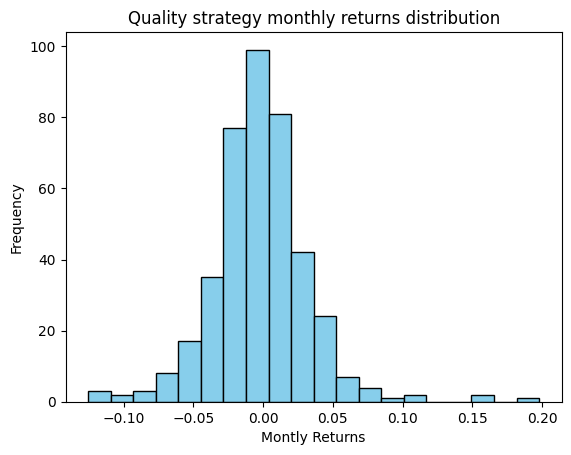

In [260]:
plot_hist(Q_rets['H-L'], strategy='Quality')

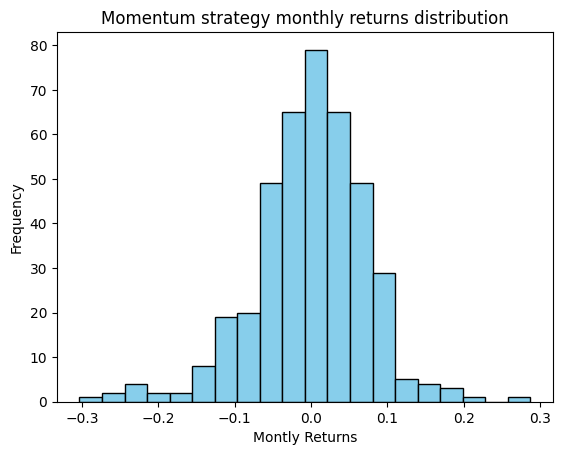

In [261]:
plot_hist(M_rets['H-L'], strategy='Momentum')

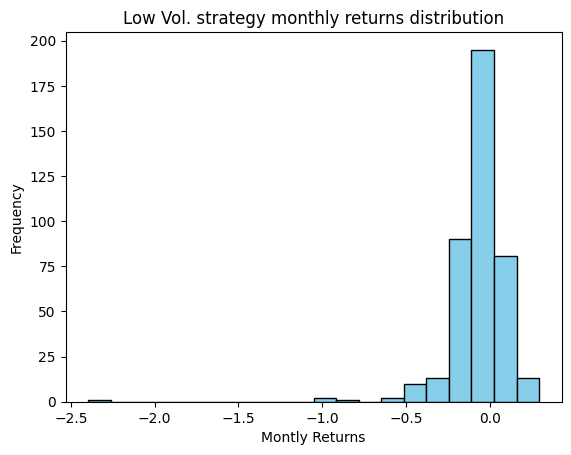

In [262]:
plot_hist(LV_rets['L-H'], strategy='Low Vol.')

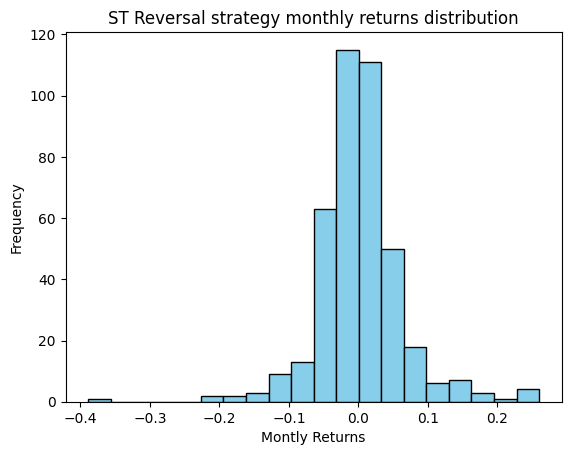

In [263]:
plot_hist(STR_rets['L-H'], strategy='ST Reversal')

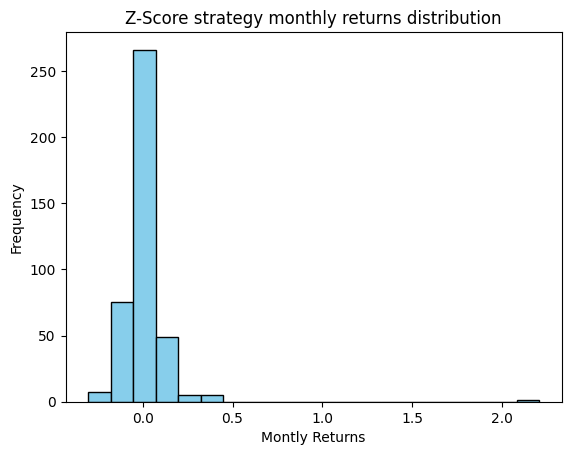

In [264]:
plot_hist(Z_rets['H-L'], strategy='Z-Score')